In [ ]:
import gym
import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
!pip install gym[classic_control]
#pip install gym[box2d] #for lunarlander
!apt update
!apt install xvfb
!pip install pyvirtualdisplay
!pip install gym-notebook-wrapper
import gnwrapper
!nvidia-smi
print(torch.cuda.is_available())

In [ ]:
class Agent(nn.Module):
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.P = PolicyNetwork(input_dim, output_dim, width)
        self.P.to(device)
        self.P.train()  
        self.P_optimizer = torch.optim.Adam(self.P.parameters(), lr=0.0003)
        self.V = ValueNetwork(input_dim, output_dim, width)
        self.V.to(device)        
        self.V.train()
        self.V_optimizer = torch.optim.Adam(self.V.parameters(), lr=0.0003) 
        self.trajectory = []       
        self.env = gym.make(game_name)        

    def play_and_update_actor_critic(self):
        game_score = 0
        state = self.env.reset() 
        I = 1            
        while True:
            output = self.P(torch.from_numpy(state).float().to(device)) 
            inferenced_v = self.V(torch.from_numpy(state).float().to(device))
            prob_distribution = Categorical(output) 
            action = prob_distribution.sample()
            state, r, done, _ = self.env.step(action.item())   
            gradient_policy_a_s = prob_distribution.log_prob(action)
            with torch.no_grad():
                inferenced_v_from_next_s = self.V(torch.from_numpy(state).float().to(device))
            if done==True:
                inferenced_v_from_next_s = 0
            delta = r + 0.99*inferenced_v_from_next_s - inferenced_v
            V_loss = -1 * I * delta.item() * inferenced_v               
            self.V_optimizer.zero_grad()
            V_loss.backward()
            self.V_optimizer.step()
            P_loss = -1 * I *  delta.item() * gradient_policy_a_s            
            self.P_optimizer.zero_grad()
            P_loss.backward()
            self.P_optimizer.step() 
            I = 0.99 * I
            game_score += r                 
            if done:
                break
        return game_score

class PolicyNetwork(nn.Module):  
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_dim, width)
        self.layer2 = torch.nn.Linear(width, width) 
        self.layer3 = torch.nn.Linear(width, output_dim) 

    def forward(self, x):
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        x = self.layer3(x)
        x = torch.nn.functional.softmax(x, dim=0)
        return x

class ValueNetwork(nn.Module): 
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_dim, width)
        self.layer2 = torch.nn.Linear(width, width) 
        self.layer3 = torch.nn.Linear(width, 1) 

    def forward(self, x):
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        x = self.layer3(x)
        return x

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
score_arr = []
game_name = 'CartPole-v1' #LunarLander-v2
env = gym.make(game_name) 
agent = Agent(env.observation_space.shape[0], env.action_space.n, 128) 
print(agent)
env.close()

#Self play, weight update
episode_nums = 500 #LunarLander-v2 1500
for i in range(episode_nums):
    game_score = agent.play_and_update_actor_critic()
    score_arr.append(game_score)  
    if i%50==0 : print('episode', i)    
torch.save(agent.state_dict(), 'weights.pt') 
agent.env.close()

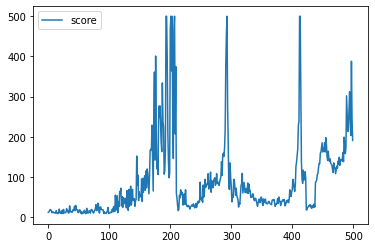

In [ ]:
#Score
plt.plot(score_arr, label ='score')
plt.legend(loc='upper left')

In [ ]:
#play video
agent.load_state_dict(torch.load("weights.pt"))
env = gnwrapper.LoopAnimation(gym.make(game_name)) 
state = env.reset()
for _ in range(200):
    with torch.no_grad():
        output = agent.P(torch.from_numpy(state).float().to(device))
        prob_distribution = Categorical(output) 
        action = prob_distribution.sample() 
    env.render()
    state, rew, done, _ = env.step(action.item())
    if done:
        state = env.reset()
env.display()